In [77]:
import luigi
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '/home/fbuonerba/codes/')
from mp_functions import upload_log_return, upload_factor_loadings
from coinapi_v1 import CoinAPIv1
import datetime
from datetime import datetime, timedelta
import time
import calendar
import json
import urllib.request
import multiprocessing as mp
import sklearn
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [96]:
#####Returns: April 2nd to May 2nd#####

with open('/home/fbuonerba/codes/meta_data/top_coins.txt') as ff:
    coins=json.load(ff)
coins=list(coins)
####LIZA is outlier for 2 of the risk factors...####
coins.remove('LIZA')
quotes=['USD','BTC']
#sysm=[str(coin)+'_'+str(quote) for coin in coins for quote in quotes]
t=1522627200
matrix=[]
#matrix of daily log_returns (time, base_quote)
while t<=1525219201:
    ret_t=[]
    for base in coins:
        for quote in quotes:
            returns=upload_log_return(t, base, quote, 86400)
            if np.isnan(returns)==True:
                returns=0
            ret_t.append(returns)
            #print(base,quote)
    matrix.append(ret_t)
    t+=86400
R=np.array(matrix)
norms=np.linalg.norm(R, axis=0)
W=np.where(norms==0)
R=np.delete(R, W, axis=1)

In [97]:
#####Factors: January to April#####
#####log_mkcap and coin_ratio computed averaging.
factors=[]
factor_names0=['variance_']
factor_names1=['strength_', 'high_low_']
factor_names2=['turnover_', 'log_mkcap_']
factor_names3=['coin_ratio_']
path='/home/fbuonerba/factor_loadings/'
finpath1='_'+str(1515283200)+'_'+str(1522540800)+'_'+str(604800)+'.txt'
finpath2='_'+str(1515283200)+'_'+str(1522540800)+'.txt'
finpath3='.txt'
for base in coins:
    for quote in quotes:
        sym=str(base)+'_'+str(quote)
        sym_row=[]
        for name in factor_names0:
            with open(path+name+sym+finpath1) as file:
                x=json.load(file)
            x=np.sqrt(x)
            sym_row.append(x)
        for name in factor_names1:
            with open(path+name+sym+finpath1) as file:
                x=json.load(file)
            sym_row.append(x)
        for name in factor_names2:
            with open(path+name+sym+finpath2) as file:
                x=json.load(file)
            sym_row.append(x)
        for name in factor_names3:
            #symll=sym.split('_')
            with open(path+name+base+finpath3) as file:
                x=json.load(file)
            sym_row.append(x)
        #sym_row.append(1)
        factors.append(sym_row)
factors=np.array(factors) 
factors=np.delete(factors, W, axis=0)
#####here we do normalization using z-score along coin axis#####
factors=(factors-np.mean(factors,axis=0))/np.var(factors,axis=0)**.5

In [79]:
#####Factors: January to April#####
#####Factors computed using Barra definitions
factors=[]
factor_names1_=['variance_']
factor_names1=['strength_', 'high_low_']
factor_names2=['turnover_']
factor_names2_=['log_mkcap_']
factor_names3=['coin_ratio_']
path='/home/fbuonerba/factor_loadings/'
finpath1='_'+str(1515283200)+'_'+str(1522540800)+'_'+str(604800)+'.txt'
finpath2='_'+str(1515283200)+'_'+str(1522540800)+'.txt'
finpath3='.txt'
for base in coins:
    for quote in quotes:
        sym=str(base)+'_'+str(quote)
        sym_row=[]
        for name in factor_names1_:
            with open(path+name+sym+finpath1) as file:
                x=json.load(file)
            x=np.sqrt(x)
            sym_row.append(x)
        for name in factor_names1:
            with open(path+name+sym+finpath1) as file:
                x=json.load(file)
            sym_row.append(x)
        for name in factor_names2:
            with open(path+name+sym+finpath2) as file:
                x=json.load(file)
            sym_row.append(x)
        for name in factor_names2_:
            with open(path+name+'exact'+'_'+sym+'_'+str(1522540800)+'.txt') as file:
                x=json.load(file)
            sym_row.append(x)
        for name in factor_names3:
            #symll=sym.split('_')
            with open(path+name+'exact'+'_'+base+'_'+str(1522540800)+'.txt') as file:
                x=json.load(file)
            sym_row.append(x)
        #sym_row.append(1)
        factors.append(sym_row)
factors=np.array(factors)  
factors=np.delete(factors, W, axis=0)
#normalization using z-score along coin axis:
factors=(factors-np.mean(factors,axis=0))/np.var(factors,axis=0)**.5

In [93]:
#make a vector of returns variance to be used in regression as weights
varia=[]
path='/home/fbuonerba/factor_loadings/'
finp='_'+str(1515283200)+'_'+str(1522540800)+'_'+str(604800)+'.txt'
for base in coins:
    for quote in quotes:
        sym=str(base)+'_'+str(quote)
        with open(path+'variance_'+sym+finpath1) as file:
            x=json.load(file)
        if x==0:
            x=float('inf')
        varia.append(x)
varia=np.array(varia)
weight=varia**-1
weight=np.delete(weight, W)


R=R*weight
factors=(factors.T*weight).T


In [98]:
####regression against returns from April 2nd to May 2nd; loadings computed on April 1st.####
reg=linear_model.LinearRegression()
#sklearn automatically preprocesses the data by removing np.mean(axis=0)#

print(R.shape)
reg.fit(factors,R.T)#,sample_weight=weight)
beta=reg.coef_
inter=reg.intercept_
inter=inter.reshape(-1,1)
total_beta=np.hstack((beta,inter)) 
total_factors=np.hstack((factors, np.ones(factors.shape[0]).reshape(-1,1)))
R_hat=reg.predict(factors) #predicted returns = (tot_fact).(tot_beta.T)
#####compute r_squared and F_scores#####
#numpy and sklearn have built-in functions computing r2.
#reg.score computes the mean along axis=0
#r2_score computes the mean over full matrix. Example:
#r2_score(R.T,R_hat1,multioutput='variance_weighted')
residuals=R.T-R_hat
R_mean=np.mean(R.T,axis=0) #daily average return
tss=np.sum( (R.T-R_mean)**2, axis=0 ) #daily total_sum_squares
rss=np.sum( (R.T-R_hat)**2, axis=0 ) #daily residual_sum_squares ~ var residuals
r2=1-rss/tss #daily R^2
cov_residuals=np.dot(residuals.T,residuals)/(factors.shape[0]-factors.shape[1])#daily
var_residuals=cov_residuals.diagonal() #daily unbiased variance of residuals
F=((tss-rss)/factors.shape[1])/var_residuals #daily F-scores
#####compute z_scores, using total_beta and total_factors for compactness#####
inv=np.linalg.inv(np.dot(total_factors.T,total_factors)) #usual (X^T.X)^{-1}
cov_beta=np.tensordot(inv,var_residuals, axes=0) #daily covariance of betas: inv*var(residual)
var_beta=cov_beta.diagonal() #daily variance of betas
std_beta=np.sqrt(var_beta) #daily standard errors
z_scores=total_beta/std_beta
df_list=[]

r2_st=r2

for t in range(30):
    df=pd.DataFrame()
    df1=pd.DataFrame()
    df['factor_name']=['returns_variance', 'returns_strength', 'returns_high_low', 'turnover', 'average_log_mkcap', 'average_coin_ratio','1']
    df['beta']=total_beta[t]
    df['std_error']=std_beta[t]
    df['z_score']=z_scores[t]
    df1['r_squared']=np.array([r2[t]])
    df1['F_score']=np.array([F[t]])
    df_list.append([df,df1])




(31, 80)


In [222]:
###compute covariance of factor returns###
#either compute cov of total_beta; or compute cov of beta, and attach a 1x1 block with inter.
#results are slightly different - intercept and beta are slightly correlated over time.
ess_cov=np.cov(beta.T)
ess_totcov=np.cov(total_beta.T)
ess1=np.hstack((ess_cov, np.zeros(6).reshape(-1,1)))
ess2=np.vstack((ess1, np.zeros(7).reshape(1,-1)))
ess2[-1,-1]=np.var(inter)

C=np.cov(inter.T[0],beta.T[0])
C[0,0]/C[0,1]


10.497551205566545

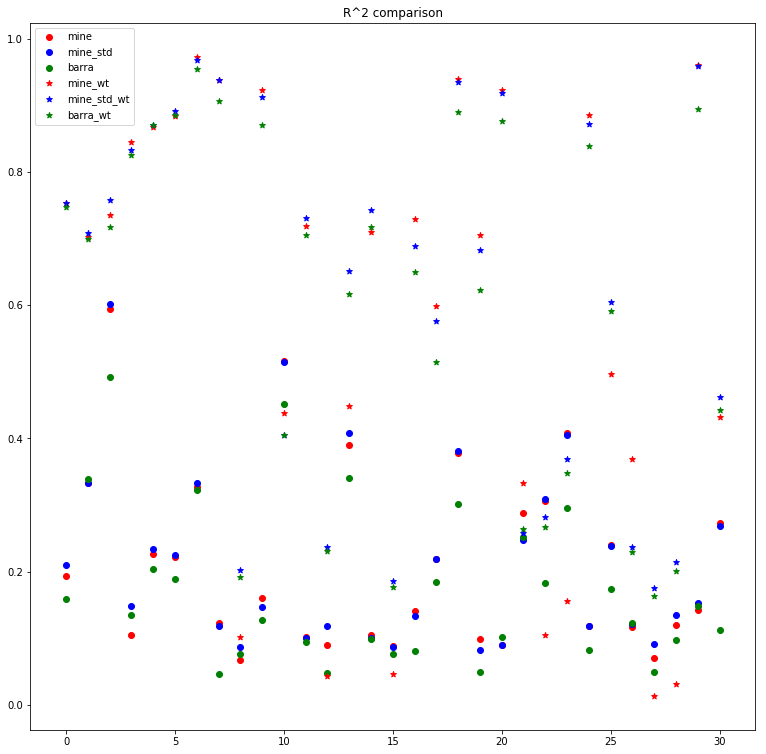

In [107]:
####results of computing 6 different regressions:
####two with averaged factors, one with literal barra factors.
####each is computed ordinary, and weighted by var(returns)^{-1}.

t=list(range(31))
fig = plt.figure(figsize=(13, 13))
plt.title('R^2 comparison')
plt.scatter(t, r2_my, c='r', label='mine')
plt.scatter(t, r2_st,c='b', label='mine_std')
plt.scatter(t, r2_barra, c='g', label='barra')
plt.scatter(t, r2_my_wt, c='r', label='mine_wt',marker='*')
plt.scatter(t, r2_st_wt, c='b', label='mine_std_wt',marker='*')
plt.scatter(t, r2_barra_wt, c='g', label='barra_wt',marker='*')
plt.legend()
plt.savefig('R^2_comparison.png')
plt.show()



array([2, 4])

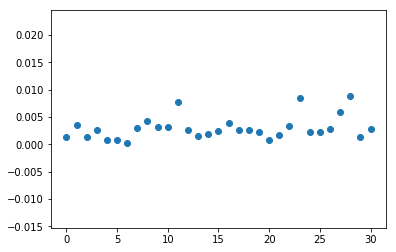

In [113]:
###looking for homoscedasticity: variance of errors independent of time/estimated returns:

####white test for homoscedasticity: regress squared-error against regressors, check r2.
resi=residuals**2
reg.fit(factors, resi)
residuals_hat=reg.predict(factors)
resmean=np.mean(resi,axis=0) #daily average return
tss=np.sum( (resi-resmean)**2, axis=0 ) #daily total_sum_squares
rss=np.sum( (resi- residuals_hat)**2, axis=0 ) #daily residual_sum_squares ~ var residuals
r2=1-rss/tss #daily R^2

#compute covariance of error timeseries: TT_t,s=cov(err_t,err_s).
#TT should be close to a homothety
TT=np.cov(residuals.T)
TTD=TT.diagonal()
plt.scatter(range(len(TTD)),TTD)
#on each row, pick column with maximal entry and check if it's diagonal.
#works beautifully, T is almost diagonal
MAX=np.argmax(TT,axis=0)
MAX-list(range(len(TT)))



In [132]:
####looking for patterns in variance of returns versus marketcap.

pathh='/home/fbuonerba/factor_loadings/'
mkcap_list_usd=[]
mkcap_list_btc=[]
variance_usd=[]
variance_btc=[]
for coin in coins:
    with open(pathh+'log_mkcap_exact_'+str(coin)+'_USD_1531612800.txt')as uo:
        mcap=json.load(uo)
    mkcap_list_usd.append(mcap)
    with open(pathh+'log_mkcap_exact_'+str(coin)+'_BTC_1531612800.txt')as uoo:
        cap=json.load(uoo)
    mkcap_list_btc.append(cap)
    with open(pathh+'variance_'+str(coin)+'_USD_1524355200_1531612800_604800.txt')as uo:
        var=json.load(uo)
    variance_usd.append(var)
    with open(pathh+'variance_'+str(coin)+'_BTC_1524355200_1531612800_604800.txt')as uoo:
        varr=json.load(uoo)
    variance_btc.append(varr)

order_usd=np.argsort(np.array(mkcap_list_usd))
order_btc=np.argsort(np.array(mkcap_list_btc))
new_var_usd=[variance_usd[x] for x in order_usd]
new_var_btc=[variance_btc[x] for x in order_btc]


[ 0 33 29 15 12 17 21 26 31 20 28 22 41 25 23 39 24 27 40 30 38 37 32 36
 11 18 34 43 35  6 14  7  8 19 13 10 42 16  3  5  4  2  9  1]


report2.0


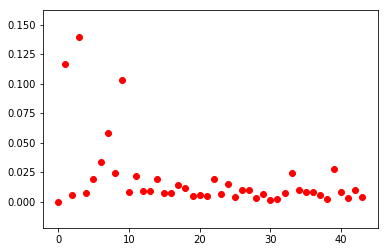

In [133]:
####Outliers = HB,DIG,ODE for both USD and BTC.
plt.scatter(list(range(len(new_var_btc))), new_var_btc, c='r', label='btc')
plt.savefig('ordered_var_btc.png')

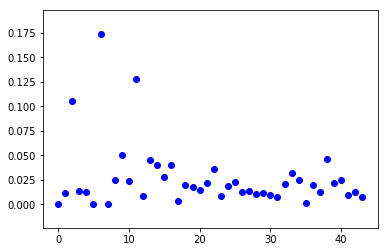

In [128]:
plt.scatter(list(range(len(new_var_usd))), new_var_usd, c='b', label='usd')
plt.savefig('ordered_var_usd.png')

In [ ]:
#report printout
print('Definition of factors, for each coin pair:')
print('*returns_variance = var(returns_t), over weekly returns Jan 7th-Apr 1st.')
print('*returns_strength=sum_t( log(1+return_t) ) over returns as above.')
print('*returns_high_low=log( max_t(return_t)/min_t(return_t) ) over returns as above.')
print('*turnover=(total traded volume)/(average coin supply) over trades Jan 7th-Apr 1st.')
print('*log_mkcap=average_t( log(coin_supply_t*price_t) ) over weekly supply and price Jan 7th-Apr 1st.')
print('*coin_ratio=average_t(coin_supply_t/coin_supply_ever) over weekly supply as above.')
print('Factor loadings have been scaled by z-score.')
print('')
for y in df_list:    
    for x in y:
        print(x)

In [5]:
#####regression against returns on April 1st only#####
t=1522540800
ret=[]
for base in coins:
    for quote in quotes:
        returns=upload_log_return(t, base, quote, 86400)
        if np.isnan(returns)==True:
            returns=0
        ret.append(returns)
ret=np.array(ret)
reg=linear_model.LinearRegression()
reg.fit(factors,ret.T)
beta=reg.coef_
inter=reg.intercept_
ret_hat=reg.predict(factors)
rss=np.linalg.norm(ret-ret_hat)**2
var_error=rss/(factors.shape[0]-factors.shape[1])
tss=np.linalg.norm(ret-np.mean(ret))**2
r_square=1-rss/tss
F_score=(tss-rss)/(factors.shape[1]*var_error)
cov_beta=np.linalg.inv(np.dot(factors.T,factors))*var_error
std_errors=np.sqrt(cov_beta.diagonal())
t_stats=beta/std_errors

df=pd.DataFrame()
df['factor_name']=['returns_variance', 'returns_strength', 'returns_high_low', 'turnover', 'log_mkcap', 'coin_ratio']
df['beta']=beta
df['std_error']=std_errors
df['z_score']=t_stats
df1=pd.DataFrame()
df1['r_squared']=np.array([r_square])
df1['F_score']=np.array([F_score])
print('Regression on April 1st returns.')
print('Definition of factors, for each coin pair:')
print('*returns_variance = var(returns_t), over weekly returns Jan 7th-Apr 1st.')
print('*returns_strength=sum_t( log(1+return_t) ) over returns as above.')
print('*returns_high_low=log( max_t(return_t)/min_t(return_t) ) over returns as above.')
print('*turnover=(total traded volume)/(average coin supply) over trades Jan 7th-Apr 1st.')
print('*log_mkcap=average_t( log(coin_supply_t*price_t) ) over weekly supply and price Jan 7th-Apr 1st.')
print('*coin_ratio=average_t(coin_supply_t/coin_supply_ever) over weekly supply as above.')
print('Factor loadings have been scaled by z-score.')
print('')
print(df)
print(df1)

Regression on April 1st returns.
Definition of factors, for each coin pair:
*returns_variance = var(returns_t), over weekly returns Jan 7th-Apr 1st.
*returns_strength=sum_t( log(1+return_t) ) over returns as above.
*returns_high_low=log( max_t(return_t)/min_t(return_t) ) over returns as above.
*turnover=(total traded volume)/(average coin supply) over trades Jan 7th-Apr 1st.
*log_mkcap=average_t( log(coin_supply_t*price_t) ) over weekly supply and price Jan 7th-Apr 1st.
*coin_ratio=average_t(coin_supply_t/coin_supply_ever) over weekly supply as above.
Factor loadings have been scaled by z-score.

        factor_name      beta  std_error   z_score
0  returns_variance -0.001987   0.004414 -0.450239
1  returns_strength  0.010160   0.005653  1.797171
2  returns_high_low  0.005005   0.007338  0.682049
3          turnover -0.000110   0.003473 -0.031699
4         log_mkcap -0.010219   0.005275 -1.937250
5        coin_ratio  0.005506   0.003640  1.512765
   r_squared   F_score
0   0.190144  3.

In [ ]:
#####February to May#####

from mp_functions import upload_log_return
with open('/home/fbuonerba/codes/meta_data/top_coins.txt') as ff:
    coins=json.load(ff)
coins=list(coins)
####LIZA is outlier for 2 of the risk factors...####
coins.remove('LIZA')
quotes=['USD','BTC']
#sysm=[str(coin)+'_'+str(quote) for coin in coins for quote in quotes]
t=1517702400
matrix=[]
#matrix of daily log_returns (time, base_quote)
while t<=1525564801:
    ret_t=[]
    for base in coins:
        for quote in quotes:
            returns=upload_log_return(t, base, quote, 86400)
            if np.isnan(returns)==True:
                returns=0
            ret_t.append(returns)
            #print(base,quote)
    matrix.append(ret_t)
    t+=86400
R=np.array(matrix)

factors=[]
factor_names1=['variance_', 'strength_', 'high_low_']
factor_names2=['turnover_', 'log_mkcap_']
factor_names3=['coin_ratio_']
path='/home/fbuonerba/codes/factor_loadings/'
finpath1='_'+str(1517702400)+'_'+str(1525564800)+'_'+str(604800)+'.txt'
finpath2='_'+str(1517702400)+'_'+str(1525564800)+'.txt'
finpath3='.txt'
for base in coins:
    for quote in quotes:
        sym=str(base)+'_'+str(quote)
        sym_row=[]
        for name in factor_names1:
            with open(path+name+sym+finpath1) as file:
                x=json.load(file)
            sym_row.append(x)
        for name in factor_names2:
            with open(path+name+sym+finpath2) as file:
                x=json.load(file)
            sym_row.append(x)
        for name in factor_names3:
            #symll=sym.split('_')
            with open(path+name+base+finpath3) as file:
                x=json.load(file)
            sym_row.append(x)
        #sym_row.append(1)
        factors.append(sym_row)
factors=np.array(factors)  
#normalization using z-score along coin axis:
factors=(factors-np.mean(factors,axis=0))/np.var(factors,axis=0)**.5
#X_with_ones = np.hstack((np.ones((factors.shape[0], 1)), factors))

In [ ]:
######################################################
######################################################
######################################################

In [ ]:
#regression against each one single time, BTC/USD
factor_test=factors
r=[]
for i in range(8):
    R_test=R[i]
    beta_test=np.linalg.lstsq(factor_test,R_test.T, rcond=None)
    S=np.dot(factors,beta_test[0])
    res_test=np.linalg.norm(R_test-S)**2
    r.append(1-res_test/np.linalg.norm(R_test)**2)
r=np.array(r)
print(np.max(r), np.min(r))

In [ ]:
reg=linear_model.LinearRegression()
for i in range(6):
    fac=factors.T[i].reshape(-1,1)
    ret=R[8].T
    #print(fac.shape)
    reg.fit(fac,ret)
    temp_beta=reg.coef_[0]
    temp_inter=reg.intercept_
    print(temp_beta, temp_inter)
    print(reg.score(fac,ret))
    plt.plot(fac, ret,'o')
    plt.plot(fac, temp_beta*fac + temp_inter, 'r', label='Fitted line')
    plt.show()

In [ ]:
for t in range(88):
    print(coins[int(t/2)],quotes[t%2])
    plt.plot(range(len(R)), R.T[t])
    plt.show()